In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [94]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, GRU

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

from sklearn.model_selection import StratifiedKFold

from keras.initializers import Constant

In [ ]:
!pip install nltk

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/timcrawley/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [35]:
# Function to plot the roc curve
def plot_roc(pred, y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

In [23]:
# Function to clean and lemmatize the review text
def clean_and_tokenize(string):
    lem = WordNetLemmatizer()
    return " ".join([lem.lemmatize(word.lower()) for word in word_tokenize(re.sub(r"[^\w\s]", "", string))])

In [ ]:
# Function to read in the GloVe embeddings
def load_glove_embeddings(embedding_file_path):
    embeddings_index = {}
    with open(embedding_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    file.close()
    return embeddings_index

In [47]:
df_data = pd.read_csv("shuffled_reviews.csv")

In [48]:
df_data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,vIOvJgTG6uqr44wWKG1sSA,klVVXdFPCoCd5XZzipHgSQ,18eWJFJbXyR9j_5xfcRLYA,4,0,0,0,This is a great Thai place! The environment is...,2016-07-10 03:21:59
1,tMYiUEzBtzJSc1F0FbZNlA,8WvvSOO3YHA9kwRuDpN8rw,HCqmx4ENAZ76SAjoalj-MQ,5,0,0,0,This is some of the best food I had while visi...,2015-04-21 02:57:34
2,cCc-pQlv5h3mKjgsZzFuMw,K4l-QrTWeAjb5xOXd81iGw,KVwQkBd8tJCDVc8O6_tMOg,1,0,1,0,I am continuing my search for good Chinese foo...,2015-03-20 22:49:03
3,9mh9OULxgSUma7UA9YQZvw,nfJDqzVr_WyNRWCeqb82Pw,1_hDCN3iioFR3XnUr32ZtA,4,0,0,0,Everything here tastes fresh. It may not be 10...,2013-04-11 19:29:06
4,rOQhPVWloqQbiOrctdss1g,RiM4StqnPPmg20dvGvvr4g,TV81bpCQ6p6o4Hau5hk-zw,5,0,0,0,Wonderful food! Love the food and the service ...,2015-07-04 20:03:45


In [50]:
df_data = df_data.copy().drop(columns=["review_id", "user_id", "business_id", "useful", "funny", "cool", "date"])

In [51]:
df_data["cleaned_tokens"] = df_data["text"].apply(clean_and_tokenize)

In [52]:
df_data

,stars,text,cleaned_tokens
0,4,This is a great Thai place! The environment is...,this is a great thai place the environment is ...
1,5,This is some of the best food I had while visi...,this is some of the best food i had while visi...
2,1,I am continuing my search for good Chinese foo...,i am continuing my search for good chinese foo...
3,4,Everything here tastes fresh. It may not be 10...,everything here taste fresh it may not be 100 ...
4,5,Wonderful food! Love the food and the service ...,wonderful food love the food and the service i...
...,...,...,...
99995,1,"We were there for around 10 minutes, and no on...",we were there for around 10 minute and no one ...
99996,3,Got chicken tikka masala & garlic naan! Delive...,got chicken tikka masala garlic naan delivery ...
99997,4,"Great food and atmosphere, especially for fast...",great food and atmosphere especially for fast ...
99998,1,"Don't know what was up today. Went in, walked ...",dont know what wa up today went in walked up t...


In [53]:
# import the glove embeddings
embedding_file = "/Users/timcrawley/Desktop/Fall23/machinelearning/final_project/glove.twitter.27B/glove.twitter.27B.100d.txt"

# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(embedding_file)

In [54]:
# create the tokenizer
tokenizer = Tokenizer(20000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_data['cleaned_tokens'])

In [55]:
sequences = tokenizer.texts_to_sequences(df_data["cleaned_tokens"])

In [56]:
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [57]:
def create_embedding_matrix(embedding_dict, word_index):
    num_words = len(word_index) + 1
    embedding_dim = len(list(embedding_dict.values())[0])
    embedding_matrix = np.zeros((num_words, embedding_dim))
    
    for word, i in word_index.items():
        if i < num_words:
            emb_vec = embedding_dict.get(word)
            if emb_vec is not None:
                embedding_matrix[i] = emb_vec
    
    return embedding_matrix

In [58]:
embedding_matrix = create_embedding_matrix(glove_embeddings, tokenizer.word_index)

In [59]:
# encode labels
le = LabelEncoder()
df_data['encoded_labels'] = le.fit_transform(df_data['stars'])
df_data[['stars', 'encoded_labels']]

,stars,encoded_labels
0,4,3
1,5,4
2,1,0
3,4,3
4,5,4
...,...,...
99995,1,0
99996,3,2
99997,4,3
99998,1,0


In [60]:
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, df_data['encoded_labels'], test_size=0.1, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [61]:
X_train

array([[  84,    4,  349, ...,    0,    0,    0],
       [  93,   41,   25, ...,    0,    0,    0],
       [ 351,  258,   10, ...,    0,    0,    0],
       ...,
       [   5,   61,  169, ...,    0,    0,    0],
       [  18,    7,   33, ...,    0,    0,    0],
       [  41,    2, 2146, ...,    0,    0,    0]], dtype=int32)

In [65]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, 
                    output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=False))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 971, 100)          9165200   
                                                                 
 flatten_3 (Flatten)         (None, 97100)             0         
                                                                 
 dense_12 (Dense)            (None, 32)                3107232   
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 16)               

In [67]:
history = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
176/176 [==============================] - 32s 170ms/step - loss: 1.5352 - accuracy: 0.2779 - val_loss: 1.3371 - val_accuracy: 0.4116
Epoch 2/10
176/176 [==============================] - 30s 169ms/step - loss: 1.3635 - accuracy: 0.3780 - val_loss: 1.2506 - val_accuracy: 0.4406
Epoch 3/10
176/176 [==============================] - 29s 163ms/step - loss: 1.2770 - accuracy: 0.4219 - val_loss: 1.2427 - val_accuracy: 0.4502
Epoch 4/10
176/176 [==============================] - 29s 165ms/step - loss: 1.2324 - accuracy: 0.4449 - val_loss: 1.2308 - val_accuracy: 0.4558
Epoch 5/10
176/176 [==============================] - 29s 165ms/step - loss: 1.1968 - accuracy: 0.4631 - val_loss: 1.2453 - val_accuracy: 0.4526
Epoch 6/10
176/176 [==============================] - 30s 171ms/step - loss: 1.1732 - accuracy: 0.4752 - val_loss: 1.2410 - val_accuracy: 0.4538
Epoch 7/10
176/176 [==============================] - 31s 174ms/step - loss: 1.1511 - accuracy: 0.4866 - val_loss: 1.2543 - val_ac

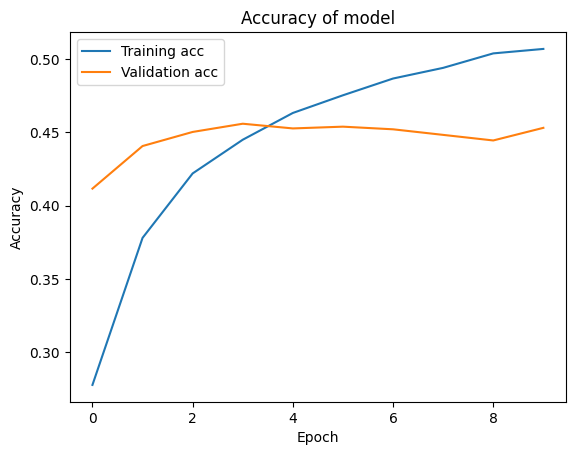

In [68]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [69]:
y_pred = model.predict(X_test)

157/157 [==============================] - 1s 5ms/step


In [70]:
predictions = []
for i in range(len(y_pred)):
    max_value = np.max(y_pred[i])
    index = np.where(y_pred==max_value)
    predictions.append(index[1][0])   

In [72]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.52      0.57       982
           1       0.39      0.46      0.42       991
           2       0.34      0.49      0.40       985
           3       0.40      0.27      0.32      1064
           4       0.60      0.56      0.58       978

    accuracy                           0.46      5000
   macro avg       0.47      0.46      0.46      5000
weighted avg       0.47      0.46      0.46      5000



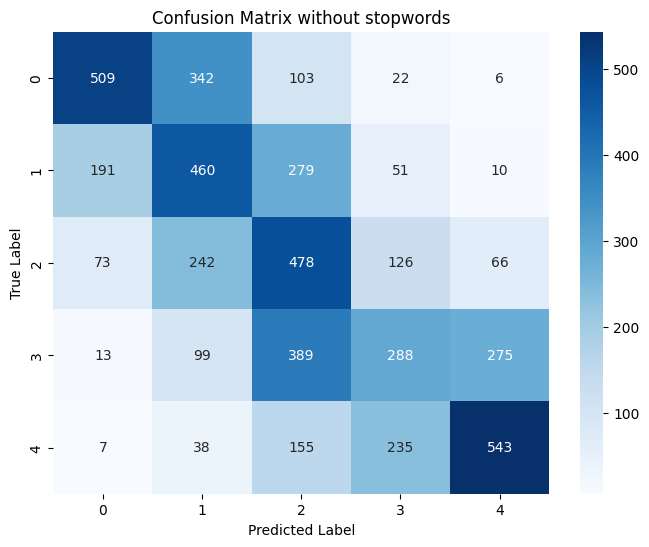

In [75]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix without stopwords")
plt.xlabel("Predicted Label")
plt.ylabel('True Label')
plt.show()

In [78]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, 
                    output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=True))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [79]:
history = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
176/176 [==============================] - 112s 622ms/step - loss: 1.4618 - accuracy: 0.3097 - val_loss: 1.2112 - val_accuracy: 0.4234
Epoch 2/10
176/176 [==============================] - 112s 635ms/step - loss: 1.2425 - accuracy: 0.4307 - val_loss: 1.1295 - val_accuracy: 0.4994
Epoch 3/10
176/176 [==============================] - 104s 594ms/step - loss: 1.1474 - accuracy: 0.4786 - val_loss: 1.0787 - val_accuracy: 0.5208
Epoch 4/10
176/176 [==============================] - 128s 729ms/step - loss: 1.0861 - accuracy: 0.5108 - val_loss: 1.0635 - val_accuracy: 0.5338
Epoch 5/10
176/176 [==============================] - 170s 967ms/step - loss: 1.0372 - accuracy: 0.5350 - val_loss: 1.0571 - val_accuracy: 0.5278
Epoch 6/10
176/176 [==============================] - 102s 580ms/step - loss: 1.0080 - accuracy: 0.5500 - val_loss: 1.0337 - val_accuracy: 0.5398
Epoch 7/10
176/176 [==============================] - 106s 602ms/step - loss: 0.9810 - accuracy: 0.5641 - val_loss: 1.0375 -

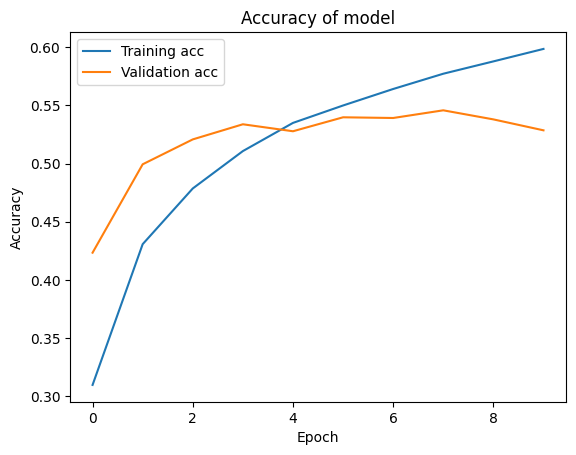

In [80]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [81]:
df_data.head()

,stars,text,cleaned_tokens,encoded_labels
0,4,This is a great Thai place! The environment is...,this is a great thai place the environment is ...,3
1,5,This is some of the best food I had while visi...,this is some of the best food i had while visi...,4
2,1,I am continuing my search for good Chinese foo...,i am continuing my search for good chinese foo...,0
3,4,Everything here tastes fresh. It may not be 10...,everything here taste fresh it may not be 100 ...,3
4,5,Wonderful food! Love the food and the service ...,wonderful food love the food and the service i...,4


In [82]:
def map_to_binary(value):
    return 1 if value >= 4 else 0

In [84]:
df_data["positive_review"] = df_data['stars'].map(map_to_binary)
df_data.head()

,stars,text,cleaned_tokens,encoded_labels,positive_review
0,4,This is a great Thai place! The environment is...,this is a great thai place the environment is ...,3,1
1,5,This is some of the best food I had while visi...,this is some of the best food i had while visi...,4,1
2,1,I am continuing my search for good Chinese foo...,i am continuing my search for good chinese foo...,0,0
3,4,Everything here tastes fresh. It may not be 10...,everything here taste fresh it may not be 100 ...,3,1
4,5,Wonderful food! Love the food and the service ...,wonderful food love the food and the service i...,4,1


In [85]:
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, df_data['positive_review'], test_size=0.1, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [86]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, 
                    output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=False))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [87]:
history = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
176/176 [==============================] - 31s 167ms/step - loss: 0.5521 - accuracy: 0.7165 - val_loss: 0.4124 - val_accuracy: 0.8016
Epoch 2/10
176/176 [==============================] - 36s 203ms/step - loss: 0.4379 - accuracy: 0.8015 - val_loss: 0.4026 - val_accuracy: 0.8096
Epoch 3/10
176/176 [==============================] - 28s 158ms/step - loss: 0.3948 - accuracy: 0.8250 - val_loss: 0.4011 - val_accuracy: 0.8108
Epoch 4/10
176/176 [==============================] - 29s 167ms/step - loss: 0.3660 - accuracy: 0.8387 - val_loss: 0.4117 - val_accuracy: 0.8078
Epoch 5/10
176/176 [==============================] - 29s 164ms/step - loss: 0.3428 - accuracy: 0.8518 - val_loss: 0.4120 - val_accuracy: 0.8088
Epoch 6/10
176/176 [==============================] - 32s 180ms/step - loss: 0.3228 - accuracy: 0.8608 - val_loss: 0.4324 - val_accuracy: 0.8150
Epoch 7/10
176/176 [==============================] - 29s 164ms/step - loss: 0.3088 - accuracy: 0.8700 - val_loss: 0.4458 - val_ac

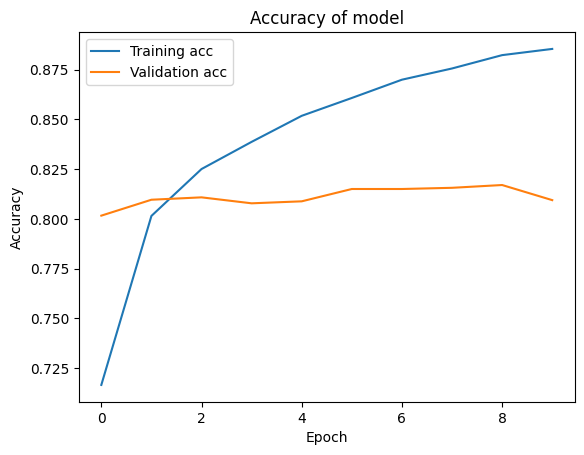

In [88]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [89]:
y_pred = model.predict(X_test)

157/157 [==============================] - 2s 9ms/step


In [90]:
predictions = []
for i in range(len(y_pred)):
    max_value = np.max(y_pred[i])
    index = np.where(y_pred==max_value)
    predictions.append(index[1][0]) 

In [91]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      2958
           1       0.75      0.69      0.71      2042

    accuracy                           0.78      5000
   macro avg       0.77      0.76      0.76      5000
weighted avg       0.77      0.78      0.77      5000



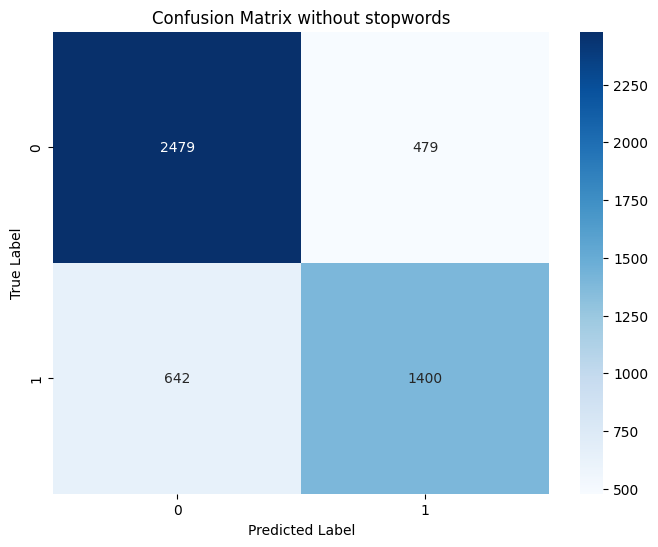

In [92]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix without stopwords")
plt.xlabel("Predicted Label")
plt.ylabel('True Label')
plt.show()

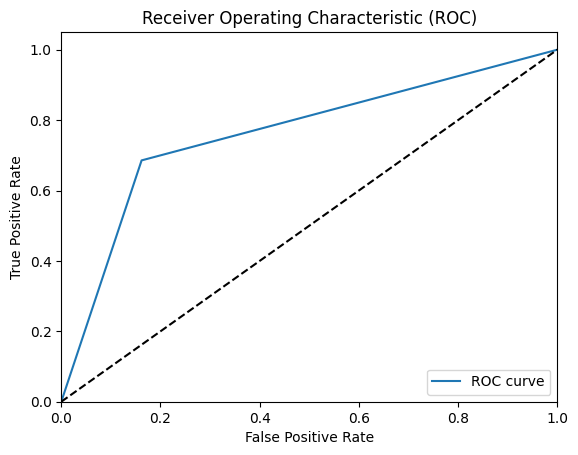

In [95]:
plot_roc(predictions, y_test)